In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from scipy.signal import spectrogram
import os
from tqdm.notebook import tqdm
import time
import concurrent.futures



%matplotlib inline

In [9]:
dtypes = {str(i): 'float64' for i in range(5000)}
dtypes.update({
    'Segment_Time': 'str',
    'lab_flag': 'int',
    'Gender': 'str',
    'Age': 'float64',
})


In [11]:
repo_location = 'D:/simedy' # Change this to the location of the repository on your machine

panel = 'CBC'
# time = '15 min'
gender_age_used = "No_GA"
# tests = os.listdir(os.path.join(repo_location, 'Notebooks/CBC'))
tests = [
#  'Eosinophils',
 'Hematocrit',
 'Hemoglobin',
#  'Lymphocytes',
#  'MCHC',
#  'MCH',
#  'MCV',
#  'Monocytes',
#  'Neutrophils',
 'Platelet Count',
#  'Red Blood Cells',
#  'RDW',
 'White Blood Cells']
tests


['Hematocrit', 'Hemoglobin', 'Platelet Count', 'White Blood Cells']

In [ ]:
# Define a dictionary of baseline models with max_iter for models that might not converge
baseline_models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Support Vector Machine': SVC(probability=True, max_iter=200),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

# Function to apply spectrogram transformation
def apply_spectrogram_transform(X, fs=125, nperseg=256):
    transformed_data = []
    for signal_data in X:
        # Compute the spectrogram
        _, _, Sxx = spectrogram(signal_data, fs=fs, nperseg=nperseg)
        transformed_data.append(Sxx.flatten())  # Flatten the 2D spectrogram into a 1D array
    return np.array(transformed_data)

# Function to train the model with timeout
def train_model_with_timeout(pipeline, X_train, y_train, timeout):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future = executor.submit(pipeline.fit, X_train, y_train)
        try:
            future.result(timeout=timeout)
        except concurrent.futures.TimeoutError:
            raise TimeoutError("Model training timed out")

# Initialize an empty DataFrame to store all results
all_results_df = pd.DataFrame()

# Number of repetitions
n_repeats = 5
timeout_duration = 600  # Timeout in seconds (e.g., 5 minutes)

for test_name in tqdm(tests, desc="Processing Tests"):
    file_name = os.path.join(repo_location, f'CSVs/Alldata_{test_name}_15 min.csv')
    vital_file_name = os.path.join(repo_location, f'CSVs/Alldata_{test_name}_15 min.csv')
    # Load the CSV file for the current test
    df = pd.read_csv(file_name, dtype=dtypes)


    # Downsampling the majority class to balance the dataset        
    df_majority = df[df.lab_flag == df.lab_flag.value_counts().index[0]]  # Replace 0 with the actual majority class label
    df_minority = df[df.lab_flag == df.lab_flag.value_counts().index[1]]  # Replace 1 with the actual minority class label

    df_majority_downsampled = df_majority

    # If the majority class is at least 5 times the size of the minority class
    if len(df_majority) / len(df_minority) >= 5:
        # Downsample majority class
        df_majority_downsampled = df_majority.sample(n=int(len(df_minority)*5), random_state=42)

    # Combine minority class with downsampled majority class
    df = pd.concat([df_majority_downsampled, df_minority])

    try:
        tqdm.write(f"Processing {test_name}")

        # Define X and y
        X = df.loc[:, '0':'1249'].values  # Assuming columns 0 to 1249 are your features
        y = df['lab_flag'].values         # Target variable
        


        # Apply spectrogram transformation to the data
        X_transformed = apply_spectrogram_transform(X)
        
        # Check if there is only one class in the target variable
        if len(np.unique(y)) < 2:
            tqdm.write(f"Skipping {test_name}: Only one class present in the target variable.")
            continue
        
        # Initialize a list to store results for the current test
        test_results = []
        
        for name, model in baseline_models.items():
            accuracy_list = []
            ppv_list = []  # Precision -> PPV
            sensitivity_list = []  # Recall -> Sensitivity
            f1_list = []
            roc_auc_list = []
            specificity_list = []
            npv_list = []
            auprc_list = []
            
            for _ in range(n_repeats):
                # Start timer for each repetition
                start_time = time.time()
                
                # Split the data into training and testing sets
                X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=None, stratify=y)
                
                if name in ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors']:
                    # Create a pipeline with scaling
                    pipeline = Pipeline([
                        ('scaler', StandardScaler()),
                        ('classifier', model)
                    ])
                else:
                    pipeline = model  # Random Forest does not need scaling
                
                try:
                    # Train the model with a timeout
                    train_model_with_timeout(pipeline, X_train, y_train, timeout=timeout_duration)
                    
                    # Predict on the test set
                    y_pred = pipeline.predict(X_test)
                    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, 'predict_proba') else None
                    
                    # Evaluate the model
                    accuracy_list.append(accuracy_score(y_test, y_pred))
                    ppv_list.append(precision_score(y_test, y_pred))
                    sensitivity_list.append(recall_score(y_test, y_pred))
                    f1_list.append(f1_score(y_test, y_pred))
                    
                    # Calculate confusion matrix to derive specificity and NPV
                    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
                    specificity = tn / (tn + fp) if (tn + fp) != 0 else np.nan
                    npv = tn / (tn + fn) if (tn + fn) != 0 else np.nan
                    specificity_list.append(specificity)
                    npv_list.append(npv)
                    
                    if y_pred_proba is not None:
                        roc_auc_list.append(roc_auc_score(y_test, y_pred_proba))
                        
                        # Calculate AUPRC
                        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
                        auprc = auc(recall, precision)
                        auprc_list.append(auprc)
                
                except TimeoutError:
                    tqdm.write(f"Skipping {test_name} repetition: Training timed out.")
                    break  # Skip to the next model
                except Exception as e:
                    tqdm.write(f"Error during model training/prediction for {test_name} with {name}: {str(e)}")
                    continue  # Skip to the next repeat
                
                # Check for long running operations within each repeat
                elapsed_time = time.time() - start_time
                if elapsed_time > timeout_duration:
                    tqdm.write(f"Skipping {test_name}: Repetition time exceeded {timeout_duration} seconds.")
                    break  # Skip to the next model

            # Calculate mean and standard deviation for each metric
            results = {
                'Test': test_name,
                'Model': name,
                'Metric': ['Accuracy', 'PPV', 'Sensitivity', 'F1 Score', 'Specificity', 'NPV', 'ROC AUC', 'AUPRC'],
                'Mean': [
                    np.mean(accuracy_list),
                    np.mean(ppv_list),
                    np.mean(sensitivity_list),
                    np.mean(f1_list),
                    np.mean(specificity_list),
                    np.mean(npv_list),
                    np.mean(roc_auc_list) if roc_auc_list else np.nan,
                    np.mean(auprc_list) if auprc_list else np.nan
                ],
                'SD': [
                    np.std(accuracy_list),
                    np.std(ppv_list),
                    np.std(sensitivity_list),
                    np.std(f1_list),
                    np.std(specificity_list),
                    np.std(npv_list),
                    np.std(roc_auc_list) if roc_auc_list else np.nan,
                    np.std(auprc_list) if auprc_list else np.nan
                ]
            }
            
            # Convert results to a DataFrame and append to test_results
            results_df = pd.DataFrame(results)
            test_results.append(results_df)
        
        # Concatenate the results for the current test and append to all_results_df
        all_results_df = pd.concat([all_results_df] + test_results, ignore_index=True)

        # Log completion time
        end_time = time.time()
        tqdm.write(f"Completed {test_name} in {end_time - start_time:.2f} seconds.")

    except Exception as e:
        tqdm.write(f"Error processing {test_name}: {str(e)}")
        continue

# Save the results to a CSV file if needed
all_results_df.to_csv('baseline_results_mean_sd.csv', index=False)


In [2]:
all_results_df = pd.read_csv('baseline_results_mean_sd.csv')
all_results_df["Mean"] = all_results_df["Mean"] * 100
all_results_df["SD"] = all_results_df["SD"] * 100

C:\Users\Abdo\AppData\Local\Temp\ipykernel_14104\237578642.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metric_winners = test_df.groupby('Metric', observed=False).apply(lambda x: x.loc[x['Mean'].idxmax()]['Model'])
C:\Users\Abdo\AppData\Local\Temp\ipykernel_14104\237578642.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metric_winners = test_df.groupby('Metric', observed=False).apply(lambda x: 

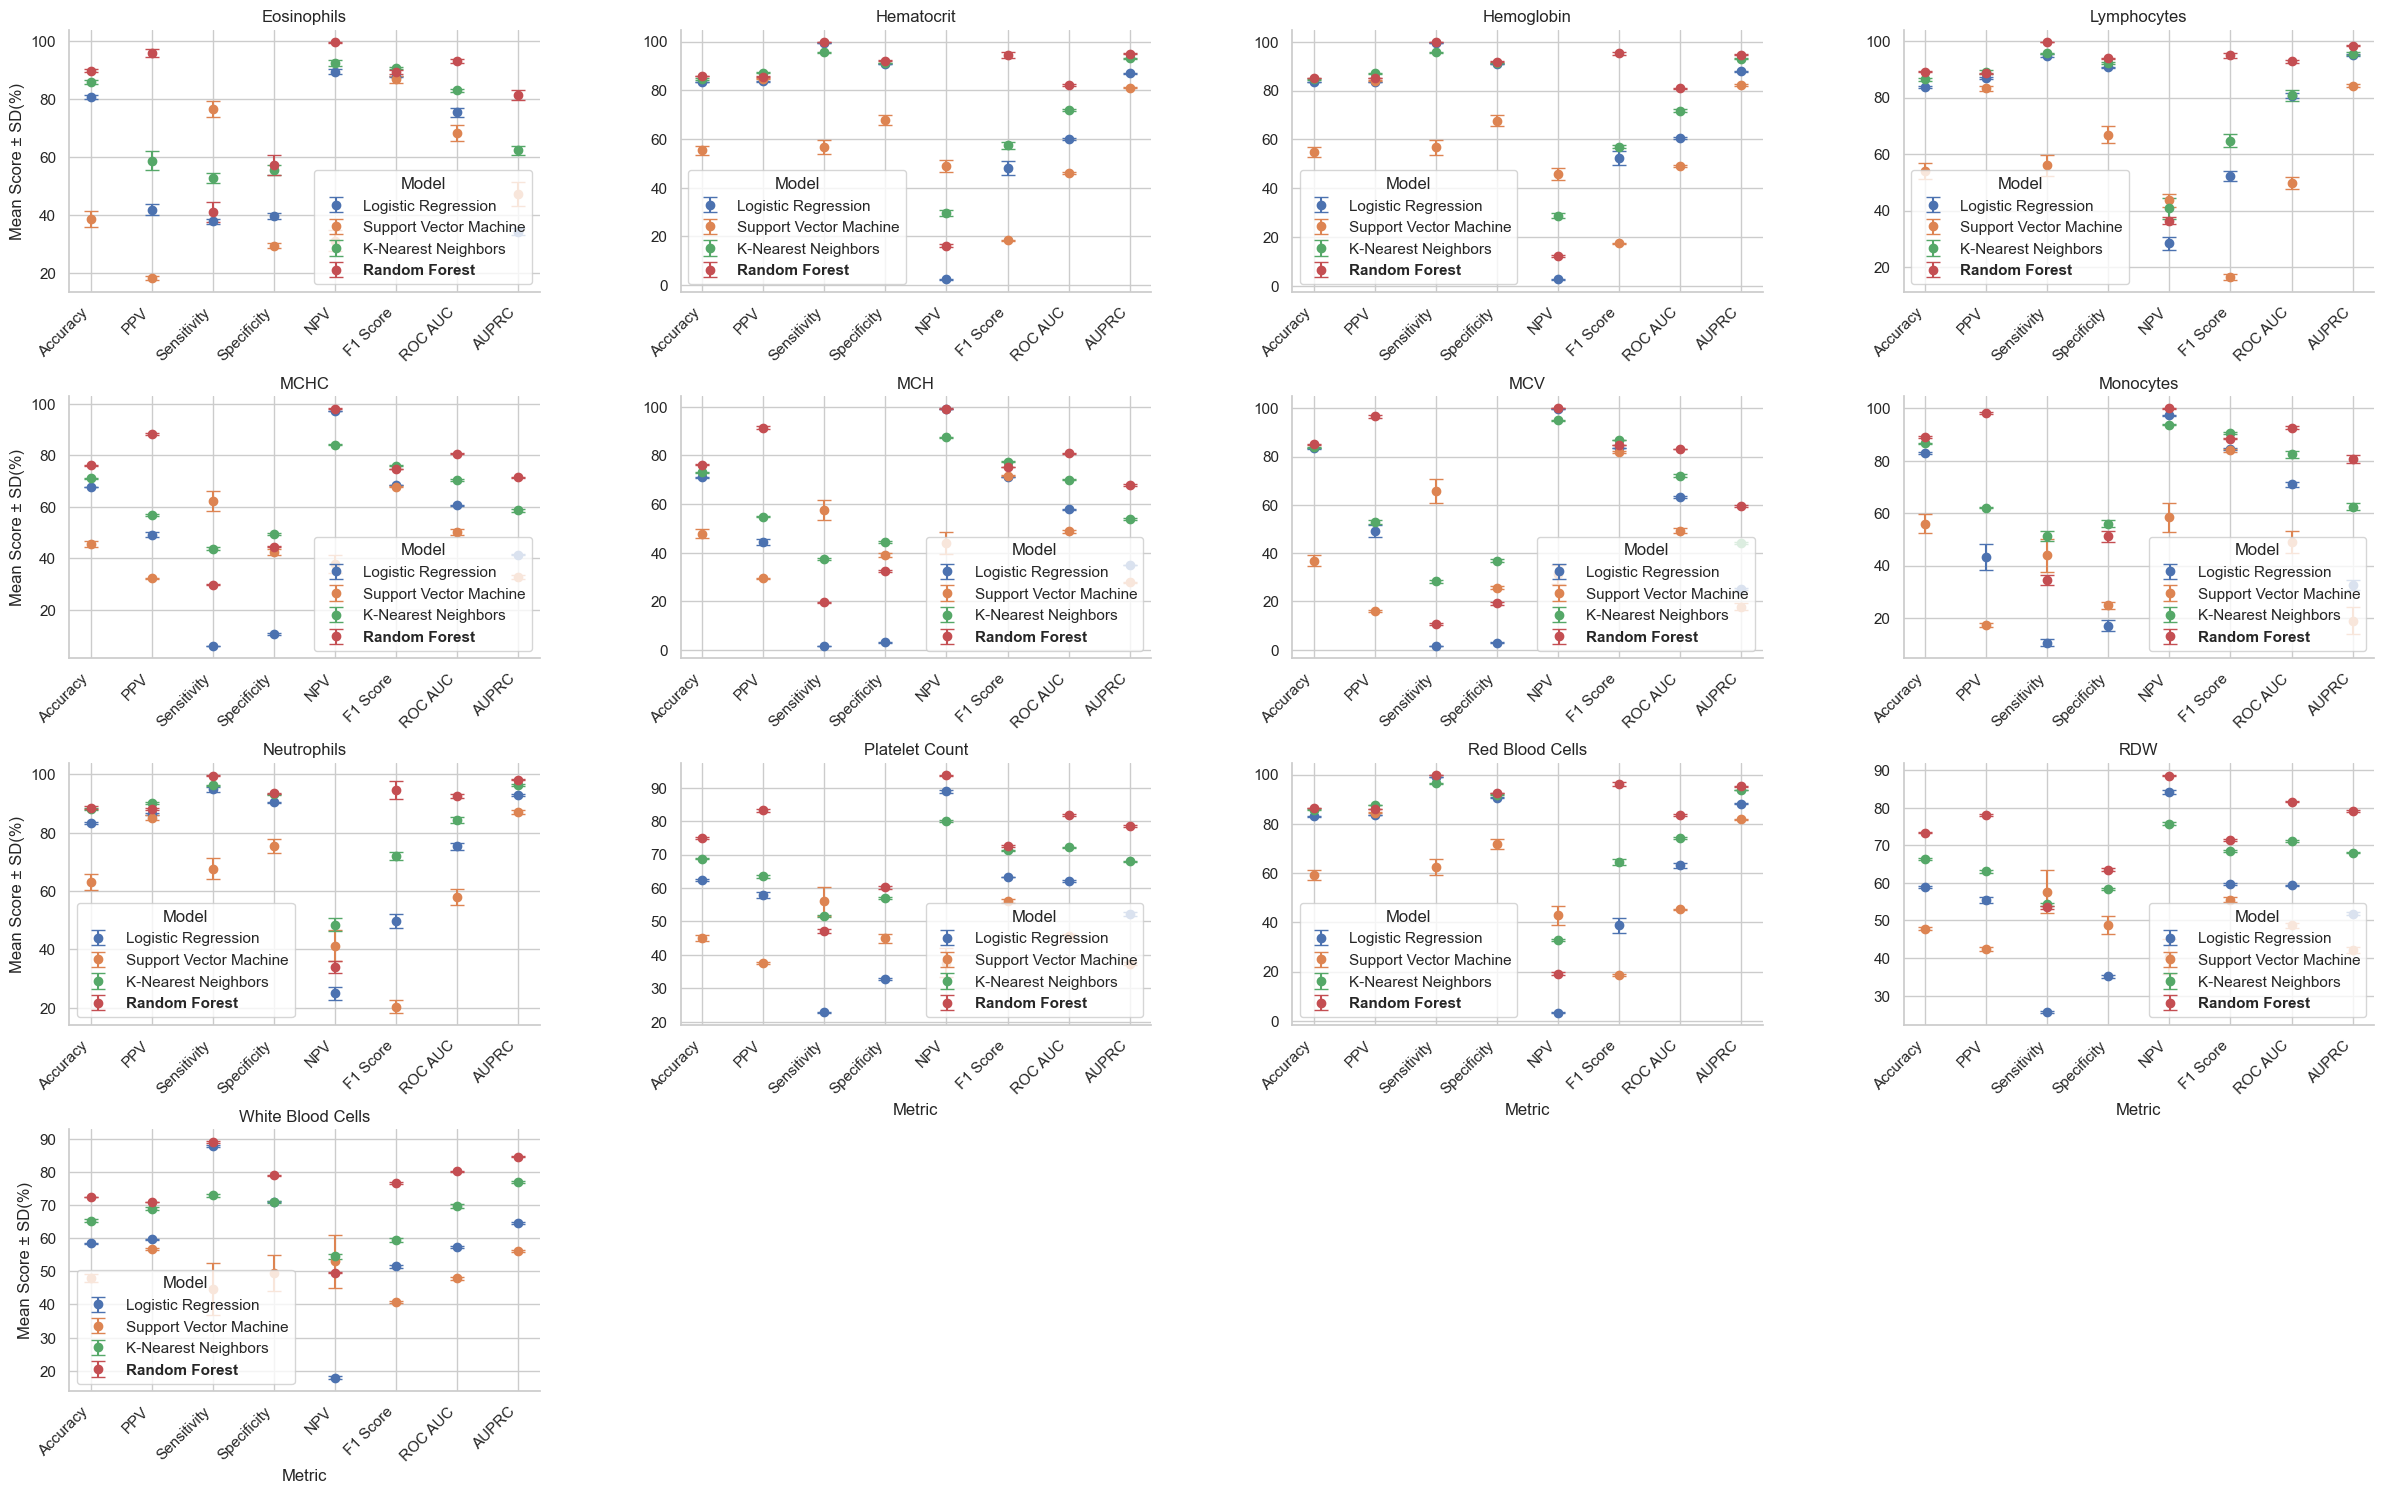

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the desired order of metrics to match the CNN plot
metric_order = ['Accuracy', 'PPV', 'Sensitivity', 'Specificity', 'NPV', 'F1 Score', 'ROC AUC', 'AUPRC']

# Ensure that the 'Metric' column in `all_results_df` follows the defined order
all_results_df['Metric'] = pd.Categorical(all_results_df['Metric'], categories=metric_order, ordered=True)

# Function to find the best model for each test based on performance across metrics
def find_best_models(df):
    best_models = []
    for test in df['Test'].unique():
        test_df = df[df['Test'] == test]
        metric_winners = test_df.groupby('Metric', observed=False).apply(lambda x: x.loc[x['Mean'].idxmax()]['Model'])
        best_model = metric_winners.value_counts().idxmax()  # Select the model that wins the most metrics
        best_models.append({'Test': test, 'Best_Model': best_model})
    return pd.DataFrame(best_models)

# Get the best models
best_models = find_best_models(all_results_df)

# Visualization using Seaborn
sns.set(style="whitegrid")

# Create the facet grid
g = sns.FacetGrid(all_results_df, col="Test", hue="Model", col_wrap=4, height=4, aspect=1.5, sharey=False, sharex=False)

# Define a custom function to plot points with error bars
def plot_with_error_bars(x, y, yerr, **kwargs):
    plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, **kwargs)

# Map the custom function to the grid
g.map(plot_with_error_bars, "Metric", "Mean", "SD")

# Adjust the x-axis labels to show the metric names in the desired order
for ax in g.axes.flat:
    ax.set_xticks(range(len(metric_order)))
    ax.set_xticklabels(metric_order, rotation=45, ha='right')

g.set_titles("{col_name}")
g.set_axis_labels("Metric", "Mean Score ± SD(%)")

# Add legend to each subplot and make the best model bold
for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles=handles, labels=labels, title="Model")
    
    # Find the best model for this test
    test = ax.get_title()
    best_model = best_models[best_models['Test'] == test]['Best_Model'].values[0]
    
    for text in legend.get_texts():
        if text.get_text() == best_model:
            text.set_fontweight('bold')

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)

# Save the plot
plt.savefig('baseline_model_comparison_mean_sd.png')

# Show the plot
plt.show()


In [ ]:
all_results_df = pd.read_csv('baseline_results_mean_sd.csv')
all_results_df["Mean"] = all_results_df["Mean"] * 100
all_results_df["SD"] = all_results_df["SD"] * 100

C:\Users\Abdo\AppData\Local\Temp\ipykernel_14104\237578642.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metric_winners = test_df.groupby('Metric', observed=False).apply(lambda x: x.loc[x['Mean'].idxmax()]['Model'])
C:\Users\Abdo\AppData\Local\Temp\ipykernel_14104\237578642.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metric_winners = test_df.groupby('Metric', observed=False).apply(lambda x: 

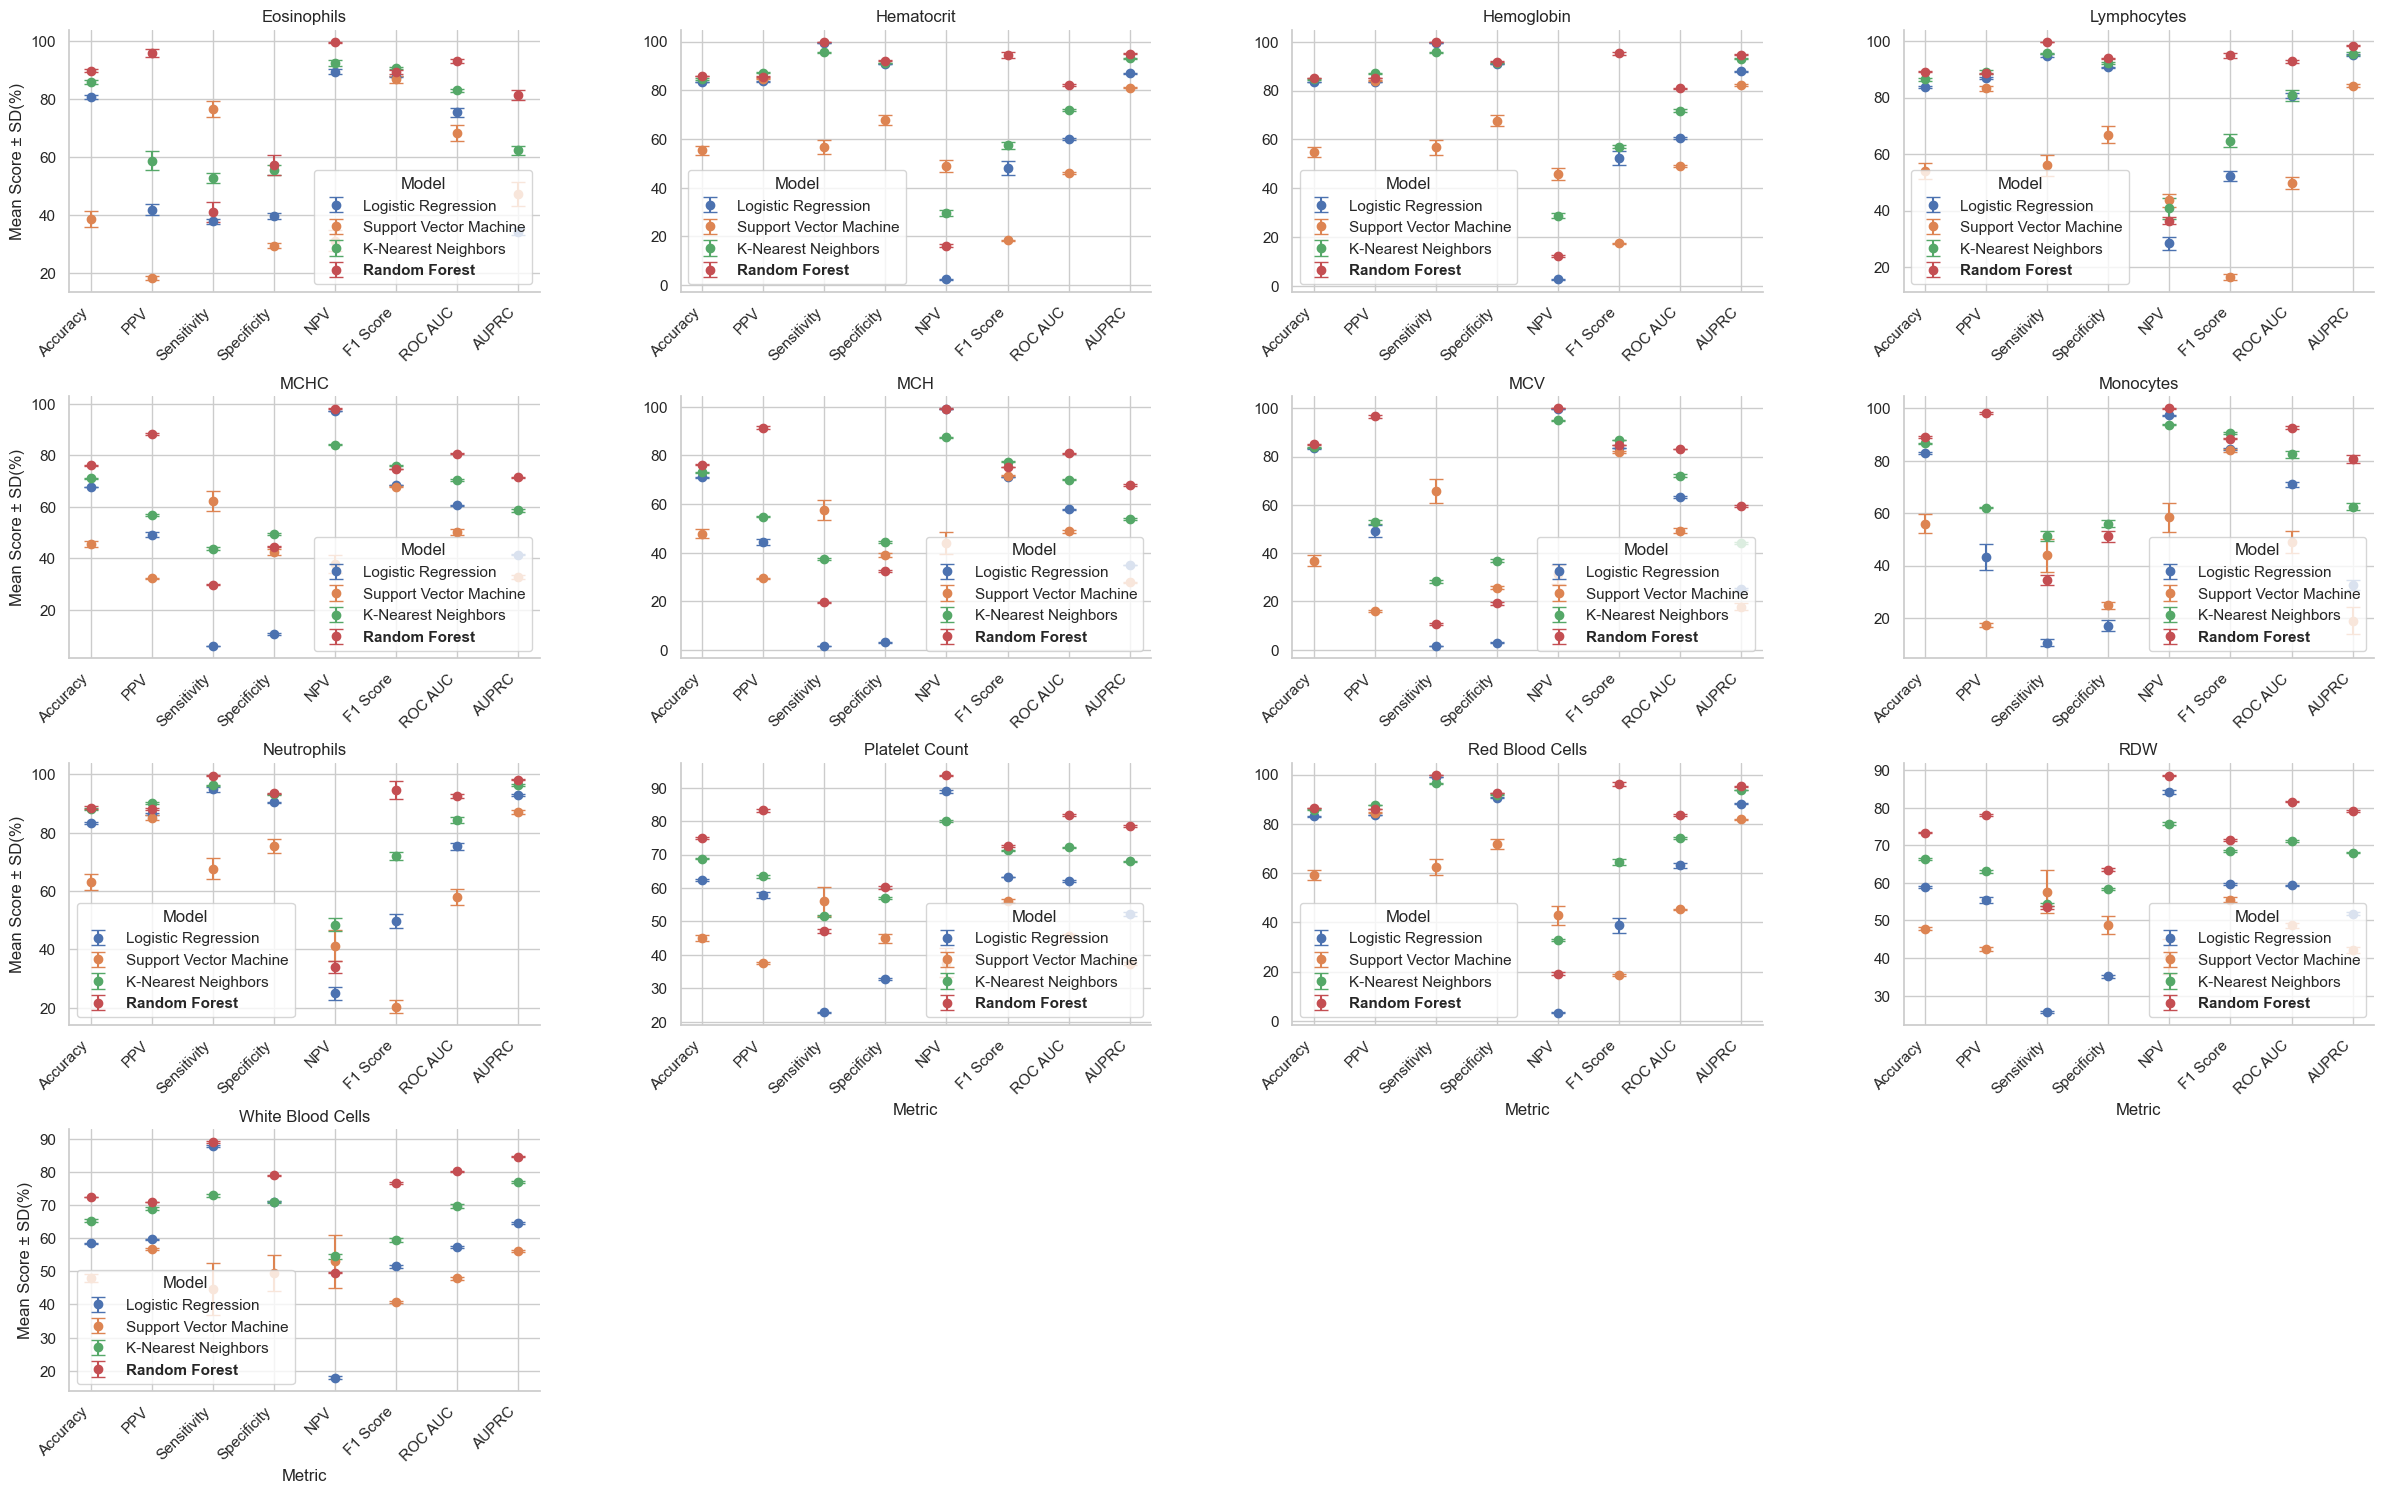

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the desired order of metrics to match the CNN plot
metric_order = ['Accuracy', 'PPV', 'Sensitivity', 'Specificity', 'NPV', 'F1 Score', 'ROC AUC', 'AUPRC']

# Ensure that the 'Metric' column in `all_results_df` follows the defined order
all_results_df['Metric'] = pd.Categorical(all_results_df['Metric'], categories=metric_order, ordered=True)

# Function to find the best model for each test based on performance across metrics
def find_best_models(df):
    best_models = []
    for test in df['Test'].unique():
        test_df = df[df['Test'] == test]
        metric_winners = test_df.groupby('Metric', observed=False).apply(lambda x: x.loc[x['Mean'].idxmax()]['Model'])
        best_model = metric_winners.value_counts().idxmax()  # Select the model that wins the most metrics
        best_models.append({'Test': test, 'Best_Model': best_model})
    return pd.DataFrame(best_models)

# Get the best models
best_models = find_best_models(all_results_df)

# Visualization using Seaborn
sns.set(style="whitegrid")

# Create the facet grid
g = sns.FacetGrid(all_results_df, col="Test", hue="Model", col_wrap=4, height=4, aspect=1.5, sharey=False, sharex=False)

# Define a custom function to plot points with error bars
def plot_with_error_bars(x, y, yerr, **kwargs):
    plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, **kwargs)

# Map the custom function to the grid
g.map(plot_with_error_bars, "Metric", "Mean", "SD")

# Adjust the x-axis labels to show the metric names in the desired order
for ax in g.axes.flat:
    ax.set_xticks(range(len(metric_order)))
    ax.set_xticklabels(metric_order, rotation=45, ha='right')

g.set_titles("{col_name}")
g.set_axis_labels("Metric", "Mean Score ± SD(%)")

# Add legend to each subplot and make the best model bold
for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles=handles, labels=labels, title="Model")
    
    # Find the best model for this test
    test = ax.get_title()
    best_model = best_models[best_models['Test'] == test]['Best_Model'].values[0]
    
    for text in legend.get_texts():
        if text.get_text() == best_model:
            text.set_fontweight('bold')

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)

# Save the plot
plt.savefig('baseline_model_comparison_mean_sd.png')

# Show the plot
plt.show()


C:\Users\Abdo\AppData\Local\Temp\ipykernel_14104\1058678944.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metric_winners = test_df.groupby('Metric', observed=False).apply(lambda x: x.loc[x['Mean'].idxmax()]['Model'])
C:\Users\Abdo\AppData\Local\Temp\ipykernel_14104\1058678944.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metric_winners = test_df.groupby('Metric', observed=False).apply(lambda x

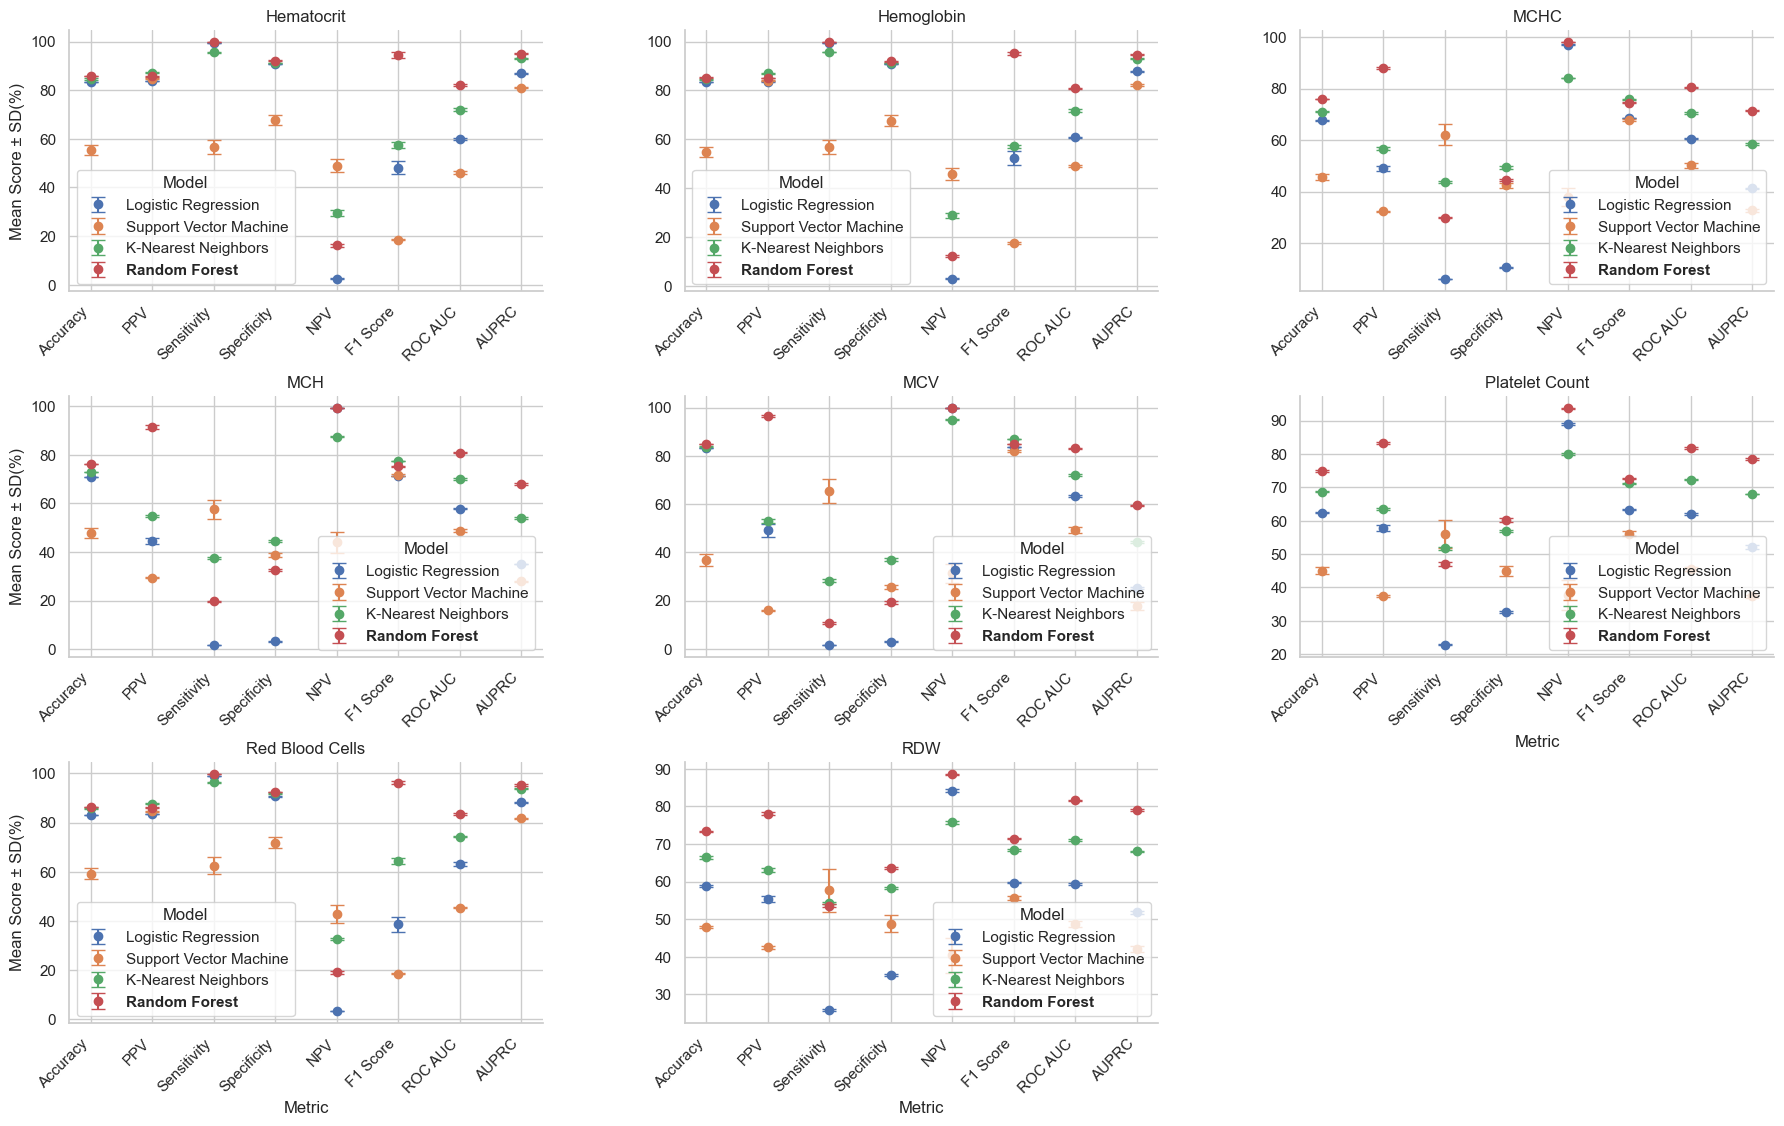

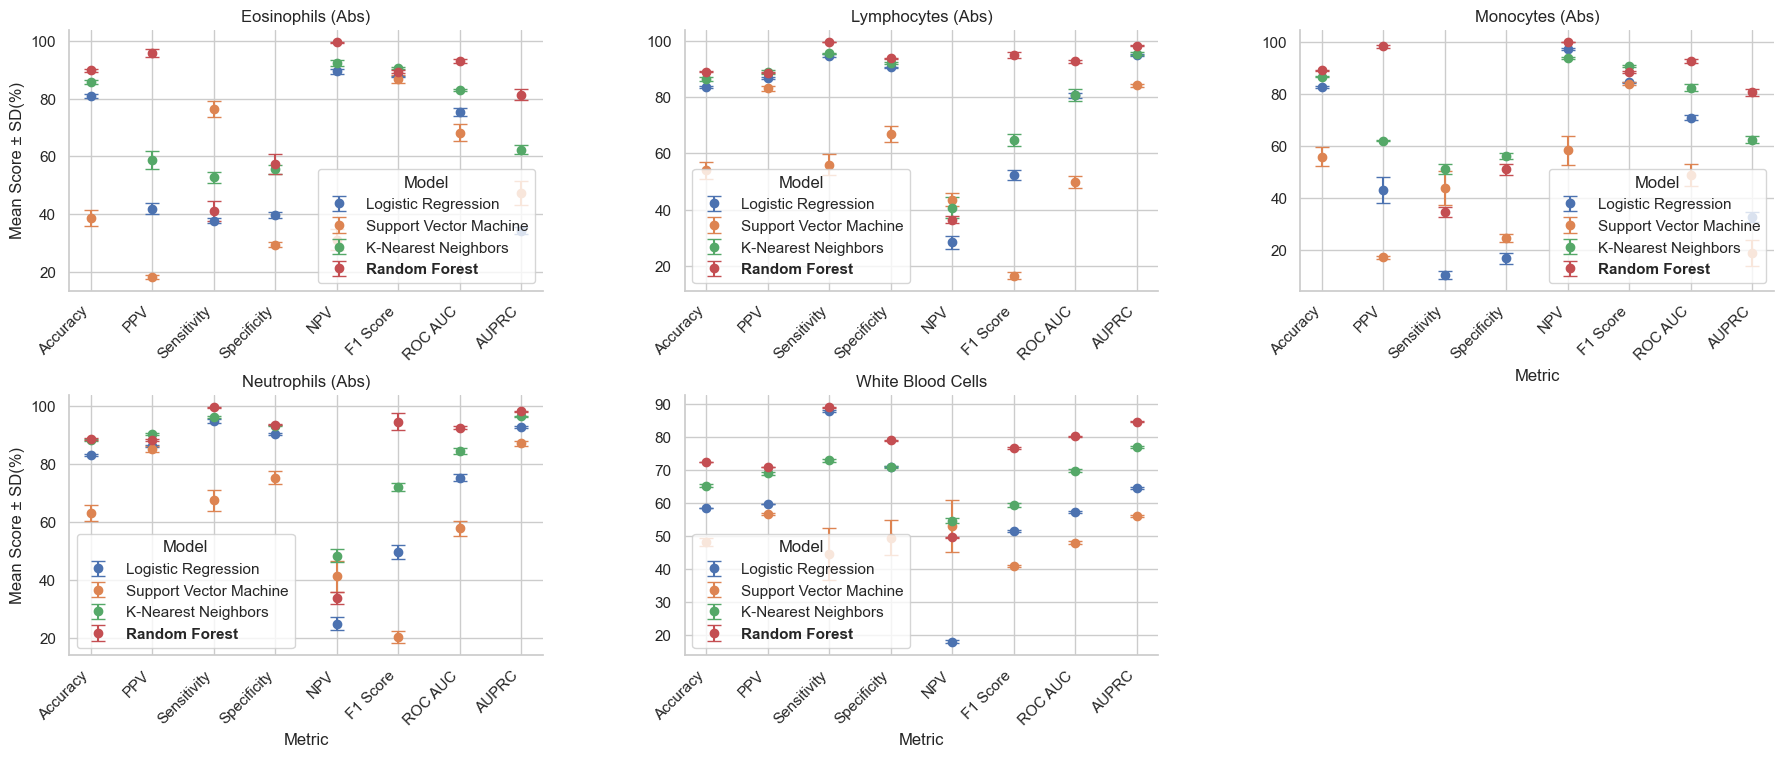

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the desired order of metrics to match the CNN plot
metric_order = ['Accuracy', 'PPV', 'Sensitivity', 'Specificity', 'NPV', 'F1 Score', 'ROC AUC', 'AUPRC']

# Ensure that the 'Metric' column in `all_results_df` follows the defined order
all_results_df['Metric'] = pd.Categorical(all_results_df['Metric'], categories=metric_order, ordered=True)

# Rename df tests
all_results_df['Test'] = all_results_df['Test'].replace({'Neutrophils':'Neutrophils (Abs)', 'Lymphocytes':'Lymphocytes (Abs)',
                                                          'Monocytes':'Monocytes (Abs)', 'Eosinophils':'Eosinophils (Abs)'})

# Function to find the best model for each test based on performance across metrics
def find_best_models(df):
    best_models = []
    for test in df['Test'].unique():
        test_df = df[df['Test'] == test]
        metric_winners = test_df.groupby('Metric', observed=False).apply(lambda x: x.loc[x['Mean'].idxmax()]['Model'])
        best_model = metric_winners.value_counts().idxmax()  # Select the model that wins the most metrics
        best_models.append({'Test': test, 'Best_Model': best_model})
    return pd.DataFrame(best_models)

# Get the best models
best_models = find_best_models(all_results_df)


# Define RBC and leukocytic test groups
rbc_tests = ['Red Blood Cells', 'Hemoglobin', 'Hematocrit', 'MCV', 'MCH', 'MCHC', 'RDW', 'Platelet Count']
leukocyte_tests = ['White Blood Cells', 'Neutrophils (Abs)', 'Lymphocytes (Abs)', 'Monocytes (Abs)', 'Eosinophils (Abs)']

# Subset DataFrames for RBC and leukocytic tests
rbc_df = all_results_df[all_results_df['test'].isin(rbc_tests)].copy()
leukocyte_df = all_results_df[all_results_df['test'].isin(leukocyte_tests)].copy()

# Remove unused categories for accurate plotting and counting
rbc_df['test'] = rbc_df['test'].cat.remove_unused_categories()
leukocyte_df['test'] = leukocyte_df['test'].cat.remove_unused_categories()

# Visualization for RBC tests
sns.set(style="whitegrid")
g_rbc = sns.FacetGrid(rbc_df, col="Test", hue="Model", col_order=rbc_tests, col_wrap=3, height=4, aspect=1.5, sharey=False, sharex=False)

# Map the custom function to the RBC grid
g_rbc.map(plot_with_error_bars, "Metric", "Mean", "SD")

# Adjust x-axis labels for RBC plot
for ax in g_rbc.axes.flat:
    ax.set_xticks(range(len(metric_order)))
    ax.set_xticklabels(metric_order, rotation=45, ha='right')

g_rbc.set_titles("{col_name}")
g_rbc.set_axis_labels("Metric", "Mean Score ± SD(%)")

# Add legend and highlight best model for RBC plot
for ax in g_rbc.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles=handles, labels=labels, title="Model")
    
    # Find the best model for this test
    test = ax.get_title()
    best_model = best_models[best_models['Test'] == test]['Best_Model'].values[0]
    
    for text in legend.get_texts():
        if text.get_text() == best_model:
            text.set_fontweight('bold')

# Adjust layout for RBC plot
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)

# Save and show RBC plot
plt.savefig('rbc_model_comparison_mean_sd.png')
plt.show()

# Visualization for leukocytic tests
g_leukocyte = sns.FacetGrid(leukocyte_df, col="Test", hue="Model", col_order=leukocyte_tests, col_wrap=3, height=4, aspect=1.5, sharey=False, sharex=False)

# Map the custom function to the leukocyte grid
g_leukocyte.map(plot_with_error_bars, "Metric", "Mean", "SD")

# Adjust x-axis labels for leukocyte plot
for ax in g_leukocyte.axes.flat:
    ax.set_xticks(range(len(metric_order)))
    ax.set_xticklabels(metric_order, rotation=45, ha='right')

g_leukocyte.set_titles("{col_name}")
g_leukocyte.set_axis_labels("Metric", "Mean Score ± SD(%)")

# Add legend and highlight best model for leukocyte plot
for ax in g_leukocyte.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles=handles, labels=labels, title="Model")
    
    # Find the best model for this test
    test = ax.get_title()
    best_model = best_models[best_models['Test'] == test]['Best_Model'].values[0]
    
    for text in legend.get_texts():
        if text.get_text() == best_model:
            text.set_fontweight('bold')

# Adjust layout for leukocyte plot
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)

# Save and show leukocyte plot
plt.savefig('leukocyte_model_comparison_mean_sd.png')
plt.show()


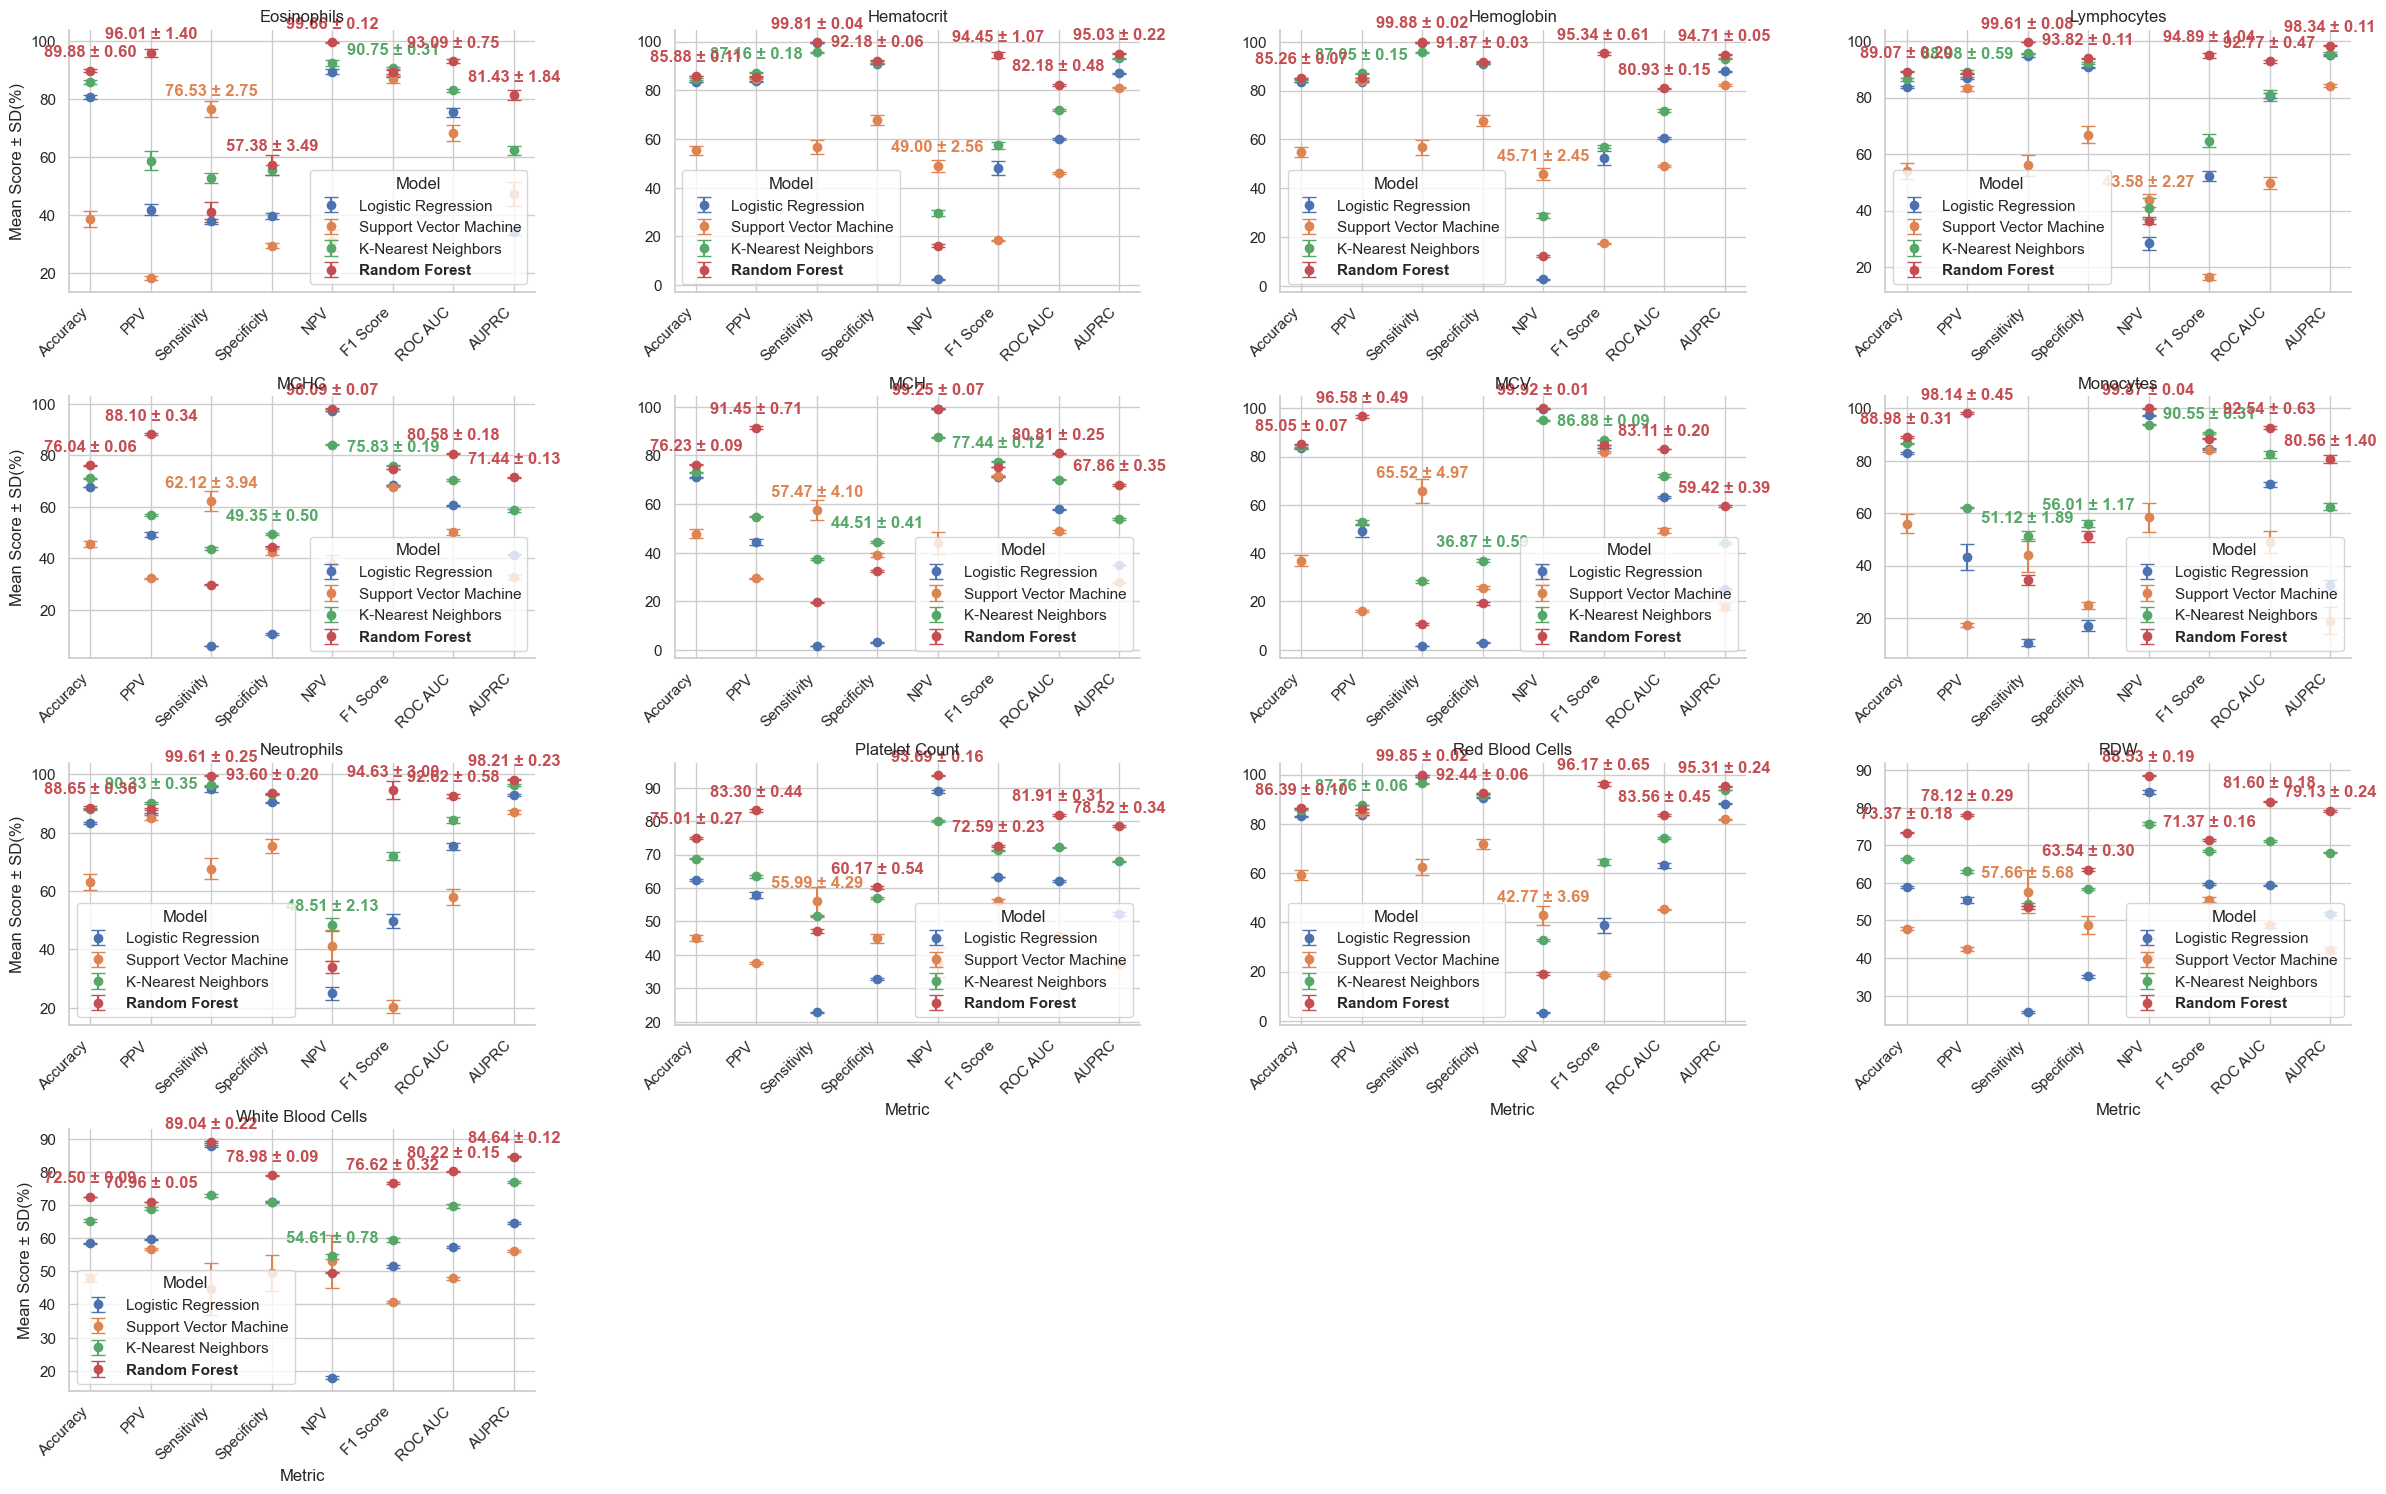

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the desired order of metrics to match the CNN plot
metric_order = ['Accuracy', 'PPV', 'Sensitivity', 'Specificity', 'NPV', 'F1 Score', 'ROC AUC', 'AUPRC']

# Ensure that the 'Metric' column in `all_results_df` follows the defined order
all_results_df['Metric'] = pd.Categorical(all_results_df['Metric'], categories=metric_order, ordered=True)

# Function to find the best model for each test and metric based on performance
def find_best_models(df):
    best_models = []
    for test in df['Test'].unique():
        test_df = df[df['Test'] == test]
        for metric in df['Metric'].unique():
            metric_df = test_df[test_df['Metric'] == metric]
            best_model = metric_df.loc[metric_df['Mean'].idxmax()]
            best_models.append({
                'Test': test,
                'Metric': metric,
                'Best_Model': best_model['Model'],
                'Mean': best_model['Mean'],
                'SD': best_model['SD']
            })
    return pd.DataFrame(best_models)

# Get the best models
best_models = find_best_models(all_results_df)

# Visualization using Seaborn
sns.set(style="whitegrid")

# Create the facet grid
g = sns.FacetGrid(all_results_df, col="Test", hue="Model", col_wrap=4, height=4, aspect=1.5, sharey=False, sharex=False)

# Define a custom function to plot points with error bars and annotate only the best-performing model
def plot_with_error_bars_and_best_annotation(data, **kwargs):
    ax = plt.gca()
    x = data['Metric']
    y = data['Mean']
    yerr = data['SD']
    plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, **kwargs)
    
    # Annotate only the best model
    for i in range(len(data)):
        # Check if the current model is the best for this metric and test
        is_best = (best_models['Test'] == data['Test'].iloc[0]) & \
                  (best_models['Metric'] == data['Metric'].iloc[i]) & \
                  (best_models['Best_Model'] == data['Model'].iloc[i])
        if is_best.any():
            annotation = f'{y.iloc[i]:.2f} ± {yerr.iloc[i]:.2f}'
            ax.annotate(annotation, (i, y.iloc[i]), 
                        textcoords="offset points", 
                        xytext=(0, 10), 
                        ha='center', 
                        color=kwargs['color'], 
                        fontweight='bold')

g.map_dataframe(plot_with_error_bars_and_best_annotation)

# Adjust the x-axis labels to show the metric names in the desired order
for ax in g.axes.flat:
    ax.set_xticks(range(len(metric_order)))
    ax.set_xticklabels(metric_order, rotation=45, ha='right')

g.set_titles("{col_name}")
g.set_axis_labels("Metric", "Mean Score ± SD(%)")

# Add legend to each subplot and make the best model bold
for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles=handles, labels=labels, title="Model")
    
    # Find the best model for this test
    test = ax.get_title()
    best_model = best_models[best_models['Test'] == test]['Best_Model'].mode()[0]
    
    for text in legend.get_texts():
        if text.get_text() == best_model:
            text.set_fontweight('bold')

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)

# Save the plot
plt.savefig('baseline_model_comparison_mean_sd_best_only.png')

# Show the plot
plt.show()


In [12]:
repo_location = 'D:/simedy' # Change this to the location of the repository on your machine

panel = 'CBC'
# time = '15 min'
gender_age_used = "No_GA"
# tests = os.listdir(os.path.join(repo_location, 'Notebooks/CBC'))
tests = [
#  'Eosinophils',
 'Hematocrit',
 'Hemoglobin',
#  'Lymphocytes',
#  'MCHC',
#  'MCH',
#  'MCV',
#  'Monocytes',
#  'Neutrophils',
 'Platelet Count',
#  'Red Blood Cells',
#  'RDW',
 'White Blood Cells']
tests


['Hematocrit', 'Hemoglobin', 'Platelet Count', 'White Blood Cells']

In [22]:
# Define a dictionary of baseline models with max_iter for models that might not converge
baseline_models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Support Vector Machine': SVC(probability=True, max_iter=200),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

# Function to apply spectrogram transformation
def apply_spectrogram_transform(X, fs=125, nperseg=256):
    transformed_data = []
    for signal_data in X:
        # Compute the spectrogram
        _, _, Sxx = spectrogram(signal_data, fs=fs, nperseg=nperseg)
        transformed_data.append(Sxx.flatten())  # Flatten the 2D spectrogram into a 1D array
    return np.array(transformed_data)

# Function to train the model with timeout
def train_model_with_timeout(pipeline, X_train, y_train, timeout):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future = executor.submit(pipeline.fit, X_train, y_train)
        try:
            future.result(timeout=timeout)
        except concurrent.futures.TimeoutError:
            raise TimeoutError("Model training timed out")

# Initialize an empty DataFrame to store all results
all_results_df = pd.DataFrame()

# Number of repetitions
n_repeats = 5
timeout_duration = 600  # Timeout in seconds (e.g., 10 minutes)

# Step 1: Train models on the original data (from CSV files) but do not test them on it
trained_models = {}  # Dictionary to store the trained models

for test_name in tqdm(tests, desc="Processing Tests"):
    for _ in range(n_repeats):    
        file_name = os.path.join(repo_location, f'CSVs/Alldata_{test_name}_15 min.csv')
        vital_file_name = os.path.join(repo_location, f'CSVs/Vital_{test_name}_15 min.csv')
        
        # Load the CSV file for the current test
        df = pd.read_csv(file_name, dtype=dtypes)
        vital_df = pd.read_csv(vital_file_name, dtype=dtypes)

        # Downsampling the majority class to balance the dataset        
        df_majority = df[df.lab_flag == df.lab_flag.value_counts().index[0]]
        df_minority = df[df.lab_flag == df.lab_flag.value_counts().index[1]]

        df_majority_downsampled = df_majority

        # If the majority class is at least 5 times the size of the minority class
        if len(df_majority) / len(df_minority) >= 5:
            # Downsample majority class
            df_majority_downsampled = df_majority.sample(n=int(len(df_minority) * 5), random_state=42)

        # Combine minority class with downsampled majority class
        df = pd.concat([df_majority_downsampled, df_minority])

        try:
            tqdm.write(f"Processing {test_name}")

            # Define X and y
            X = df.loc[:, '0':'1249'].values  # Assuming columns 0 to 1249 are your features
            y = df['lab_flag'].values         # Target variable

            # Apply spectrogram transformation to the data
            X_transformed = apply_spectrogram_transform(X)
            
            # Check if there is only one class in the target variable
            if len(np.unique(y)) < 2:
                tqdm.write(f"Skipping {test_name}: Only one class present in the target variable.")
                continue

            for name, model in baseline_models.items():
                # Initialize the pipeline based on the model type
                if name in ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors']:
                    # Create a pipeline with scaling
                    pipeline = Pipeline([
                        ('scaler', StandardScaler()),
                        ('classifier', model)
                    ])
                else:
                    pipeline = model  # Random Forest does not need scaling
                
                try:
                    # Train the model with a timeout
                    train_model_with_timeout(pipeline, X_transformed, y, timeout=timeout_duration)
                    
                    # Store the trained model for later use on vital_df
                    trained_models[name] = pipeline

                except TimeoutError:
                    tqdm.write(f"Skipping {test_name}: Training timed out.")
                    continue  # Skip to the next model
                except Exception as e:
                    tqdm.write(f"Error during model training for {test_name} with {name}: {str(e)}")
                    continue  # Skip to the next model

        except Exception as e:
            tqdm.write(f"Error processing {test_name}: {str(e)}")
            continue

        # Step 2: Use the trained models to predict on vital_df
        try:
            tqdm.write("Predicting using trained models on vital data")

            # Define X and y for vital_df
            X_vital = vital_df.loc[:, '0':'1249'].values  # Assuming columns 0 to 1249 are your features
            y_vital = vital_df['lab_flag'].values         # Target variable

            # Apply spectrogram transformation to the vital data
            X_vital_transformed = apply_spectrogram_transform(X_vital)
            
            # Check if there is only one class in the target variable for vital data
            if len(np.unique(y_vital)) < 2:
                tqdm.write("Skipping vital data: Only one class present in the target variable.")
            else:
                # Initialize a list to store results for the vital data predictions
                vital_results = []

                for name, model in trained_models.items():
                    try:
                        # Predict on the vital data set
                        y_vital_pred = model.predict(X_vital_transformed)
                        y_vital_pred_proba = model.predict_proba(X_vital_transformed)[:, 1] if hasattr(model, 'predict_proba') else None

                        # Evaluate the model on vital data
                        accuracy = accuracy_score(y_vital, y_vital_pred)
                        ppv = precision_score(y_vital, y_vital_pred)
                        sensitivity = recall_score(y_vital, y_vital_pred)
                        f1 = f1_score(y_vital, y_vital_pred)
                        
                        # Calculate confusion matrix to derive specificity and NPV
                        tn, fp, fn, tp = confusion_matrix(y_vital, y_vital_pred).ravel()
                        specificity = tn / (tn + fp) if (tn + fp) != 0 else np.nan
                        npv = tn / (tn + fn) if (tn + fn) != 0 else np.nan

                        roc_auc = roc_auc_score(y_vital, y_vital_pred_proba) if y_vital_pred_proba is not None else np.nan
                        
                        # Calculate AUPRC if probabilities are available
                        if y_vital_pred_proba is not None:
                            precision, recall, _ = precision_recall_curve(y_vital, y_vital_pred_proba)
                            auprc = auc(recall, precision)
                        else:
                            auprc = np.nan
                        
                        # Store the results for the vital data predictions
                        vital_result = {
                            'Test': test_name,
                            'Model': name,
                            'Metric': ['Accuracy', 'PPV', 'Sensitivity', 'F1 Score', 'Specificity', 'NPV', 'ROC AUC', 'AUPRC'],
                            'Score': [accuracy, ppv, sensitivity, f1, specificity, npv, roc_auc, auprc]
                        }

                        # Convert results to a DataFrame and append to vital_results
                        vital_results_df = pd.DataFrame(vital_result)
                        vital_results.append(vital_results_df)
                    
                    except Exception as e:
                        tqdm.write(f"Error predicting with {name} on vital data: {str(e)}")
                        continue  # Skip to the next model

                # Concatenate the results for vital data predictions and append to all_results_df
                all_results_df = pd.concat([all_results_df] + vital_results, ignore_index=True)

        except Exception as e:
            tqdm.write(f"Error processing vital data: {str(e)}")

# Save the results to a CSV file if needed
all_results_df.to_csv('vital_results_mean_sd.csv', index=False)


Processing Tests:   0%|          | 0/4 [00:00<?, ?it/s]

Processing Hematocrit


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data
Processing Hematocrit


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data
Processing Hematocrit


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data
Processing Hematocrit


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data
Processing Hematocrit


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data
Processing Hemoglobin


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data
Processing Hemoglobin


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data
Processing Hemoglobin


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data
Processing Hemoglobin


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data
Processing Hemoglobin


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data
Processing Platelet Count


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data
Processing Platelet Count


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data
Processing Platelet Count


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data
Processing Platelet Count


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data
Processing Platelet Count


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data
Processing White Blood Cells


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing White Blood Cells


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing White Blood Cells


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing White Blood Cells


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing White Blood Cells


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicting using trained models on vital data


c:\Users\Abdo\Anaconda3\envs\simedy2\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
all_results_df = pd.read_csv('vital_results_mean_sd.csv')
all_results_df.head(100)

,Test,Model,Metric,Score
0,Hematocrit,Logistic Regression,Accuracy,0.639588
1,Hematocrit,Logistic Regression,PPV,0.764821
2,Hematocrit,Logistic Regression,Sensitivity,0.765861
3,Hematocrit,Logistic Regression,F1 Score,0.765341
4,Hematocrit,Logistic Regression,Specificity,0.222919
...,...,...,...,...
95,Hematocrit,Random Forest,AUPRC,0.765559
96,Hematocrit,Logistic Regression,Accuracy,0.639588
97,Hematocrit,Logistic Regression,PPV,0.764821
98,Hematocrit,Logistic Regression,Sensitivity,0.765861


In [14]:
all_results_df["Score"] = all_results_df["Score"] * 100


# Define the desired order of metrics to match the CNN plot
metric_order = ['Accuracy', 'PPV', 'Sensitivity', 'Specificity', 'NPV', 'F1 Score', 'ROC AUC', 'AUPRC']

# Ensure that the 'Metric' column in `all_results_df` follows the defined order
all_results_df['Metric'] = pd.Categorical(all_results_df['Metric'], categories=metric_order, ordered=True)

# Function to find the best model for each test based on performance across metrics
def find_best_models(df):
    best_models = []
    for test in df['Test'].unique():
        test_df = df[df['Test'] == test]
        metric_winners = test_df.groupby('Metric', observed=False).apply(lambda x: x.loc[x['Mean'].idxmax()]['Model'])
        best_model = metric_winners.value_counts().idxmax()  # Select the model that wins the most metrics
        best_models.append({'Test': test, 'Best_Model': best_model})
    return pd.DataFrame(best_models)

# Get the best models
best_models = find_best_models(all_results_df)

# Visualization using Seaborn
sns.set(style="whitegrid")

# Create the facet grid
g = sns.FacetGrid(all_results_df, col="Test", hue="Model", col_wrap=4, height=4, aspect=1.5, sharey=False, sharex=False)

# Define a custom function to plot points with error bars
def plot_with_error_bars(x, y, yerr, **kwargs):
    plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, **kwargs)

# Map the custom function to the grid
g.map(plot_with_error_bars, "Metric", "Mean", "SD")

# Adjust the x-axis labels to show the metric names in the desired order
for ax in g.axes.flat:
    ax.set_xticks(range(len(metric_order)))
    ax.set_xticklabels(metric_order, rotation=45, ha='right')

g.set_titles("{col_name}")
g.set_axis_labels("Metric", "Mean Score ± SD(%)")

# Add legend to each subplot and make the best model bold
for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles=handles, labels=labels, title="Model")
    
    # Find the best model for this test
    test = ax.get_title()
    best_model = best_models[best_models['Test'] == test]['Best_Model'].values[0]
    
    for text in legend.get_texts():
        if text.get_text() == best_model:
            text.set_fontweight('bold')

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)

# Save the plot
plt.savefig('vital_baseline_testing_mean_sd.png')

# Show the plot
plt.show()


KeyError: 'Mean'